In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm
from torchsummary import summary

import numpy as np


# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정   
torch.manual_seed(123)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(123)

In [9]:
preprocess = transforms.Compose([
    transforms.Resize(28),
    
    transforms.CenterCrop(28),
    transforms.ToTensor(),
])

In [10]:
shape_label = {
    0 : 'circle',
    1 : 'square',
    2 : 'triangle',
}

In [11]:
#dataload

shapes = torchvision.datasets.ImageFolder(root = "D:/backup/LAB/datasets/RoadSign/shapes2", transform=preprocess)
shapes_trainloader = torch.utils.data.DataLoader(shapes,batch_size=16,shuffle=True)

test = torchvision.datasets.ImageFolder(root='D:/backup/LAB/datasets/RoadSign/shapes_test', transform=preprocess)
shapes_testloader = torch.utils.data.DataLoader(test)


2


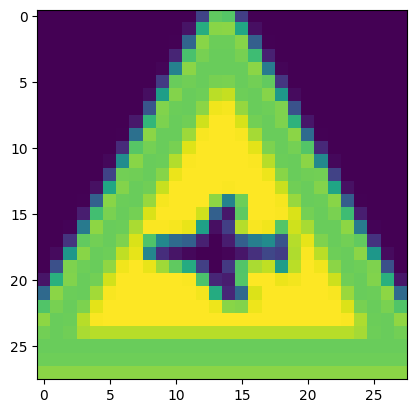

In [29]:
print(test[77][1])
plt.imshow(test[77][0][0])

In [12]:
#INPUT IMAGE : 28,28,3
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,32,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5)
        )
        
        self.dense = nn.Sequential(
            nn.Linear(64,512),
            nn.Dropout(p=0.5),
            nn.Linear(512,3)
        )
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        
        
        return out


In [13]:
#deer CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

total_batch = len(shapes_trainloader)
print('총 배치의 수 : {}'.format(total_batch))


총 배치의 수 : 701


In [14]:
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 26, 26]           9,248
              ReLU-4           [-1, 32, 26, 26]               0
         MaxPool2d-5           [-1, 32, 13, 13]               0
           Dropout-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 13, 13]          18,496
              ReLU-8           [-1, 64, 13, 13]               0
            Conv2d-9           [-1, 64, 11, 11]          36,928
             ReLU-10           [-1, 64, 11, 11]               0
        MaxPool2d-11             [-1, 64, 5, 5]               0
          Dropout-12             [-1, 64, 5, 5]               0
           Conv2d-13             [-1, 64, 5, 5]          36,928
             ReLU-14             [-1, 6

In [21]:
EPOCH = 10
PATH = 'D:/backup/LAB/code/RoadSign/model.pt'
LOSS = 0.4

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [22]:
# Train model
for epoch in tqdm(range(EPOCH)):
    avg_cost = 0

    for X, Y in shapes_trainloader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

 10%|█         | 1/10 [00:27<04:08, 27.64s/it]

[Epoch:    1] cost = 0.273829609


 20%|██        | 2/10 [00:55<03:42, 27.76s/it]

[Epoch:    2] cost = 0.104249358


 30%|███       | 3/10 [01:23<03:14, 27.79s/it]

[Epoch:    3] cost = 0.0460637473


 40%|████      | 4/10 [01:51<02:46, 27.78s/it]

[Epoch:    4] cost = 0.0250574909


 50%|█████     | 5/10 [02:18<02:19, 27.80s/it]

[Epoch:    5] cost = 0.0171548259


 60%|██████    | 6/10 [02:46<01:51, 27.89s/it]

[Epoch:    6] cost = 0.0127637526


 70%|███████   | 7/10 [03:15<01:23, 27.98s/it]

[Epoch:    7] cost = 0.0122318761


 80%|████████  | 8/10 [03:43<00:56, 28.03s/it]

[Epoch:    8] cost = 0.00789607409


 90%|█████████ | 9/10 [04:11<00:28, 28.18s/it]

[Epoch:    9] cost = 0.00566776004


100%|██████████| 10/10 [04:41<00:00, 28.11s/it]

[Epoch:   10] cost = 0.00421946868


In [24]:
correct = 0
total = 0

circle2square = 0
circle2triangle = 0
triangle2square = 0
triangle2circle = 0
square2triangle = 0
square2circle = 0

for X, Y in shapes_testloader:
    X = X.to(device)
    Y = Y.to(device)

    prediction = model(X)
    predicted = torch.argmax(prediction, 1)
    
    # if Y.item() == 3:
    #     correct+=1
        
    if predicted.item() == Y.item():
        correct+=1
        
    else:
        if predicted.item() == 0:
            if Y.item() == 1:
                circle2square+=1
            else:
                circle2triangle+=1
        elif predicted.item() == 1:
            if Y.item() == 2:
                square2triangle+=1
            else:
                square2circle+=1
        else:
            if Y.item() == 0:
                triangle2circle+=1
            else:
                triangle2square+=1
    total+=1
    
print("원형 -> 삼각형 : ", circle2triangle)
print("원형 -> 사각형 : ", circle2square)

print("사각형 -> 원형 : ", square2circle)
print("사각형 -> 삼각형 : ", square2triangle)

print("삼각형 -> 원형 : ", triangle2circle)
print("삼각형 -> 사각형 : ", triangle2square)
print(correct, '/', total)


원형 -> 삼각형 :  0
원형 -> 사각형 :  0
사각형 -> 원형 :  0
사각형 -> 삼각형 :  0
삼각형 -> 원형 :  43
삼각형 -> 사각형 :  19
45 / 107
